In [1]:
import pandas as pd
import numpy as np
from fidap import fidap_client
from datetime import datetime
from dateutil.relativedelta import relativedelta
import config
fidap = fidap_client(db="sf_gcp", api_key=config.FIDAP_API_KEY)

In [2]:
companies_data = fidap.sql(f"""SELECT R."date", MAX("ticker_value") "ticker", "idlabel_value" "article", R."pageviews"  FROM "FIDAP_DATA_SOURCES"."FIDAP_SCHEMA"."wikidata_companies" L
LEFT OUTER JOIN
(SELECT * FROM "FIDAP_DATA_SOURCES"."FIDAP_SCHEMA"."wikidata_pages" WHERE "date" > DATEADD(year, -1, CURRENT_DATE())) R ON L."idlabel_value"=R."page" WHERE R."date" IS NOT NULL GROUP BY "article", R."date", R."pageviews" ORDER BY R."date" DESC, R."pageviews" DESC;""")

# Top 10 Stocks By Views

## Over Last Day

<AxesSubplot:title={'center':'Top 10 Stocks by Views Over Last Day'}, xlabel='ticker'>

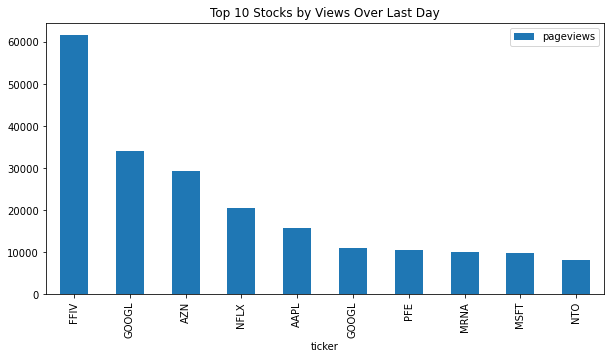

In [3]:
companies_data.head(10).plot.bar(x='ticker', y='pageviews', rot=90, figsize=(10,5), title="Top 10 Stocks by Views Over Last Day")

## Over Last Month

Get the current date and then subtract 1 month and then get records which fall in that time frame

In [4]:
monthly_df = fidap.sql(f"""SELECT R."date", MAX("ticker_value") "ticker", "idlabel_value" "article", R."pageviews"  FROM "FIDAP_DATA_SOURCES"."FIDAP_SCHEMA"."wikidata_companies" L
LEFT OUTER JOIN
(SELECT * FROM "FIDAP_DATA_SOURCES"."FIDAP_SCHEMA"."wikidata_pages" WHERE "date" > DATEADD(month, -1, CURRENT_DATE())) R ON L."idlabel_value"=R."page" WHERE R."date" IS NOT NULL GROUP BY "article", R."date", R."pageviews" ORDER BY R."pageviews" DESC LIMIT 10;""")

In [5]:
monthly_df

,date,ticker,article,pageviews
0,2021-03-03,FFIV,F5 Networks,67789
1,2021-03-09,FFIV,F5 Networks,63012
2,2021-03-04,FFIV,F5 Networks,63009
3,2021-03-10,FFIV,F5 Networks,62813
4,2021-03-16,FFIV,F5 Networks,62319
5,2021-03-11,FFIV,F5 Networks,62271
6,2021-03-08,FFIV,F5 Networks,61922
7,2021-03-17,FFIV,F5 Networks,61874
8,2021-03-18,FFIV,F5 Networks,61503
9,2021-03-15,FFIV,F5 Networks,60126


Create a Dataframe of only the past months data.

<AxesSubplot:title={'center':'Top 10 Stocks by Views Over Last Month'}, xlabel='ticker'>

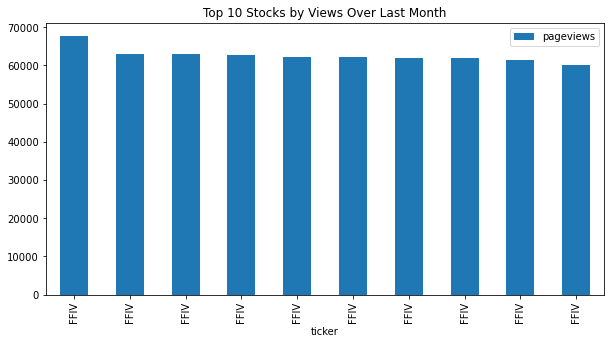

In [6]:
monthly_df.plot.bar(x='ticker', y='pageviews', rot=90, figsize=(10,5), title="Top 10 Stocks by Views Over Last Month")

## Over Last Year

We would do something like the above, we would get the current date and subtract 1 year and then get all the records in that date range.

In [7]:
yearly_df = fidap.sql(f"""SELECT R."date", MAX("ticker_value") "ticker", "idlabel_value" "article", R."pageviews"  FROM "FIDAP_DATA_SOURCES"."FIDAP_SCHEMA"."wikidata_companies" L
LEFT OUTER JOIN
(SELECT * FROM "FIDAP_DATA_SOURCES"."FIDAP_SCHEMA"."wikidata_pages" WHERE "date" > DATEADD(year, -1, CURRENT_DATE())) R ON L."idlabel_value"=R."page" WHERE R."date" IS NOT NULL GROUP BY "article", R."date", R."pageviews" ORDER BY R."pageviews" DESC LIMIT 10;""")

In [8]:
yearly_df

,date,ticker,article,pageviews
0,2020-11-09,PFE,Pfizer,302622
1,2020-11-10,PFE,Pfizer,195289
2,2021-01-28,GME,GameStop,175970
3,2021-01-29,GME,GameStop,158155
4,2020-08-25,KNM,Konami,156739
5,2020-07-30,GOOGL,Google,132930
6,2020-12-12,NET,Cloudflare,131548
7,2020-12-11,NET,Cloudflare,130435
8,2020-11-16,MRNA,Moderna,124888
9,2021-01-27,GME,GameStop,110598


<AxesSubplot:title={'center':'Top 10 Stocks by Views Over Last Year'}, xlabel='ticker'>

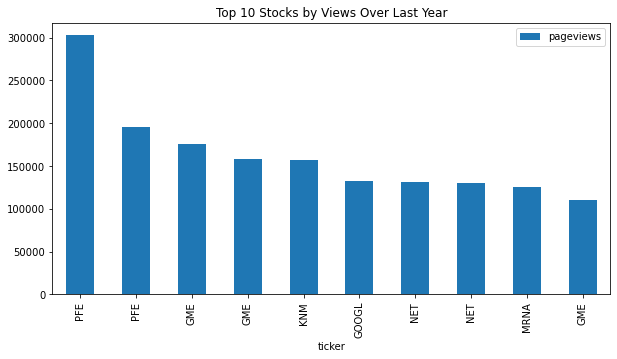

In [9]:
yearly_df.plot.bar(x='ticker', y='pageviews', rot=90, figsize=(10,5), title="Top 10 Stocks by Views Over Last Year")

# Top 10 Increase in Views

## Last Day vs Last Month Average

In [10]:
monthly_views = fidap.sql(f"""SELECT R."date", MAX("ticker_value") "ticker", "idlabel_value" "article", R."pageviews", Q."marketcap"  FROM "FIDAP_DATA_SOURCES"."FIDAP_SCHEMA"."wikidata_companies" L
LEFT OUTER JOIN
(SELECT * FROM "FIDAP_DATA_SOURCES"."FIDAP_SCHEMA"."wikidata_pages" WHERE "date" > DATEADD(month, -3, CURRENT_DATE())) R ON L."idlabel_value"=R."page" 
LEFT OUTER JOIN
(SELECT "marketcap", "ticker" FROM "FIDAP_DATA_SOURCES"."FIDAP_SCHEMA"."tickers") Q ON L."ticker_value"=Q."ticker" WHERE R."date" IS NOT NULL AND Q."marketcap" IS NOT NULL GROUP BY "article", R."date", R."pageviews", Q."marketcap" ORDER BY "ticker", R."date" DESC;""")

### Get the difference between the current day and previous day based on whether the previous days ticker value macthes the current days.

In [11]:
monthly_views.sort_values(ascending=False, by=['ticker','date'], inplace=True)
monthly_views['prev_day_views'] = np.where(monthly_views['ticker'] == monthly_views['ticker'].shift(-1), monthly_views['pageviews'].shift(-1), np.nan)

### Get the monthly average for all the tickers.

In [12]:
monthly_views['month'] = monthly_views.date.dt.to_period('M')
monthly_av = monthly_views.groupby(['month','ticker'])['pageviews'].mean().to_frame().reset_index()
monthly_av.rename(columns={'pageviews': 'monthly_average'}, inplace=True)

### Merge Tables and Get Top 10 Last Day vs. Monthly Average

In [13]:
monthly_views = monthly_views.merge(monthly_av, on=['month','ticker'])
monthly_views['prev_month_avg'] = monthly_views['prev_day_views']/monthly_views['monthly_average']
monthly_views.sort_values(ascending=False, by=['prev_month_avg']).head(10)

,date,ticker,article,pageviews,marketcap,prev_day_views,month,monthly_average,prev_month_avg
99886,2021-01-12,CPG,Crescent Point Energy,42,2.162500e+09,14793.0,2021-01,803.344828,18.414259
41808,2021-02-25,OSK,Osisko Mining,19,8.143900e+09,15133.0,2021-02,830.250000,18.227040
115098,2021-02-10,B,Barnes Group,34,2.502600e+09,1284.0,2021-02,77.214286,16.629047
30797,2021-02-09,RJF,Raymond James Financial,1845,1.671120e+10,27932.0,2021-02,1776.500000,15.723051
122433,2021-01-28,AMC,Amcor,298,4.659100e+09,29661.0,2021-01,2039.241379,14.545115
87610,2021-01-24,ET,Energy Transfer Equity,116,2.113310e+10,3459.0,2021-01,244.310345,14.158222
16155,2021-01-07,TLYS,Tillys,163,3.285000e+08,1900.0,2021-01,151.620690,12.531271
45861,2021-01-30,NVAX,Novavax,10707,1.283300e+10,58786.0,2021-01,4836.000000,12.155914
390,2021-03-03,ZS,Zscaler,4223,2.253210e+10,39177.0,2021-03,3257.611111,12.026297
99884,2021-01-13,CPG,Crescent Point Energy,31,2.162500e+09,9481.0,2021-01,803.344828,11.801906
